# Kernel Density Estimate and Nonparametric Regressions

This notebook uses non-parametric methods to estimate distributions and regressions.

# Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Statistics, StatsBase

include("jlFiles/printmat.jl")
include("jlFiles/CovNWFn.jl")
include("jlFiles/Ols.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

## Loading Data

The data consists of daily returns on U.S. large caps.

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
R   = xx[:,11]            #returns for the portfolio we want to study
xx  = nothing

y   = R[2:end]            #dependent variable
x   = R[1:end-1]          #regressor
T   = size(x,1)

println("Sample size: $T")

Sample size: 8324


# Kernel Density Estimate

The `KernDensFn()` function (below) estimates the probability density function (pdf) by using a gaussian kernel. The bandwidth parameter (`h`) can be supplied by the caller, otherwise it defaults to the rule of thumb value $h=1.06\textrm{std}(x)/T^{0.2}$. In practice, the choice of kernel is less important that the choice of bandwidth.

The estimate of the pdf at value $x$ is
$
\hat{f}\left(  x\right)  =\frac{1}{h}\frac{1}{T}\sum_{t=1}^{T}K(\frac{x_{t}-x}{h}),
$

where $K()$ is one of the kernel functions listed below.

The function outputs both the estimate the estimate of $\textrm{pdf}(x)$, denoted `fx`, and its standard deviation, denoted `Stdfx`.

As an alternative to this code, consider the [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl) package.

In [4]:
"""
Four different kernels for use with the kernel density and regression
"""
GaussianKernel(z)     = exp(-abs2(z)/2)/sqrt(2*pi)
UniformKernel(z)      = ifelse(abs(z) < sqrt(3),1/(2*sqrt(3)),0.0)                   #[-sqrt(3),sqrt(3)]
EpanechnikovKernel(z) = ifelse(abs(z) < sqrt(5),(1-abs2(z)/5)*3/(4*sqrt(5)),0.0)     #[-sqrt(5),sqrt(5)]
TriangularKernel(z)   = ifelse(abs(z) < sqrt(6),(1-abs(z)/sqrt(6))/sqrt(6),0.0)      #[-sqrt(6),sqrt(6)]

TriangularKernel (generic function with 1 method)

In [5]:
"""
    KernDensFn(x,xGrid,h=[],KernelFun=GaussianKernel)

Compute a kernel density estimate at each value of the grid `xGrid`, using the data in vector `x`. 
The bandwidth `h` can be specified (otherwise a default value is used). The kernel function
defaults to a standard normal density function, but other choices are available.
"""
function KernDensFn(x,xGrid,h=[],KernelFun=GaussianKernel)

    if isempty(h)
        h = 1.06*std(x)/T^0.2
    end

    Ngrid = length(xGrid)                          #number of grid points
    fx    = fill(NaN,Ngrid)
    for j = 1:Ngrid                                #loop over elements in xGrid
        xa    = (x .- xGrid[j])/h
        Kh    = KernelFun.(xa)
        fx[j] = mean(Kh)/h
    end

    Varfx = fx./(T*h) * 1/(2*sqrt(π))
    Stdfx = sqrt.(Varfx)                            #std[f(x)]

  return fx, Stdfx

end

KernDensFn

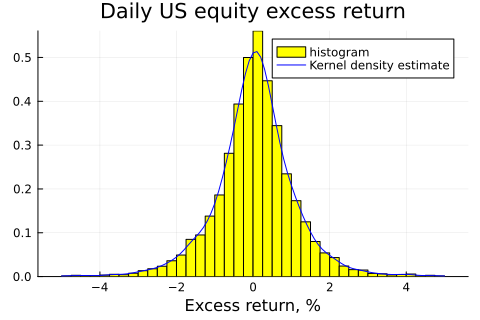

In [6]:
xGrid = -5:0.1:5
pdfX, = KernDensFn(x,xGrid)

p1 = histogram( x,bins = -5:0.25:5,
                normalized = true,
                fillcolor = :yellow,
                label = "histogram",
                title = "Daily US equity excess return",
                xlabel = "Excess return, %" )
plot!(xGrid,pdfX,linewidth=1,color=:blue,label="Kernel density estimate")
display(p1)

# Kernel Regression

is a regression of the sort 
$
y_t = b(x_{t}) + \epsilon_t
$
where regression function $b()$ is effectively assumed to be constant in a neighbourhood of a grid point $x$. Many grid points are considered, so the function is approximated by a step function: fixed value around each grid point $x$.

The fitted value of $b(x)$ (that is, evaluated a particular $x$-value) in a kernel regression is calculated as

$
\hat{b}(x)=\frac{\sum_{t=1}^{T}w(x_t-x)y_{t}}{\sum_{t=1}^{T}w(x_t-x)},
$

where $w(x_t-x)$ is the weight of observation $t$, defined by a kernel function. This can be implemnted as a regression 
of $\sqrt{w_t}y_t$ on $\sqrt{w_t}1$, which also gives a valid standard error of the estimates. (The function below uses White's method.)

The function `KernRegFn(y,x,xGrid,h,KernelFun)` uses one of the kernels listed above to do the estimation. It defaults to the Gaussian kernel.

It estimates $b(x)$ at each point $x$ in the vector `xGrid`. The function requires the user to input a bandwidth parameter `h`.

As an alternative to this code, consider the [NonparametricRegression.jl](https://github.com/tbeason/NonparametricRegression.jl) package.

In the application below, we are estimating a non-parametric AR(1) for returns.

In [7]:
"""
    KernRegFn(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)

Do kernel regression y[vv] = b(x[vv]), evaluated at xGrid vector, using bandwidth h. 
Implemented as weighted least squares (WLS), which also provide heteroskedasticity
robust standard errors.

# Input
- `y::Vector`:      T-vector with data for the dependent variable
- `x::Vector`:      T-vector with data for the regressor
- `xGrid::Vector`:  Ngrid-vector with grid points where the estimates are done
- `vv::Symbol or Vector`: If `vv = :all`, then all data points are used, otherwise supply indices.
- `DoCovb::Bool`:    If true, the standard error of the estimate is also calculated
- `KernelFun::Function`: Function used as kernel. 

# Remark
- The `vv` and `DoCovb=false` options are useful for speeding up the cross-validation below.

"""
function KernRegFn(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)

    if vv != :all
        (y,x) = (y[vv],x[vv])
    end

    Ngrid = length(xGrid)                  #number of grid points

    (bHat,StdbHat) = (fill(NaN,Ngrid),fill(NaN,Ngrid))         #b[x(t)]
    for i = 1:Ngrid                        #loop over elements in xGrid
        zi  = (x .- xGrid[i])/h
        w   = KernelFun.(zi)
        w05 = sqrt.(w)
        if DoCovb
            (b_i,_,_,Covb_i,) = OlsNWFn(w05.*y,w05,0)
            bHat[i]    = b_i
            StdbHat[i] = sqrt(Covb_i)
        else    
            bHat[i] = w05\(w05.*y)
        end    
    end

    return bHat, StdbHat

end

KernRegFn

In [8]:
xGrid = -10:0.25:10                          #x values to estimate b(x) at
h     = 1.5

(bHat,StdbHat) = KernRegFn(y,x,xGrid,h)             #baseline choice of h
bHatHih,       = KernRegFn(y,x,xGrid,h*2)           #high h
bHatLoh,       = KernRegFn(y,x,xGrid,h*0.5);        #low h

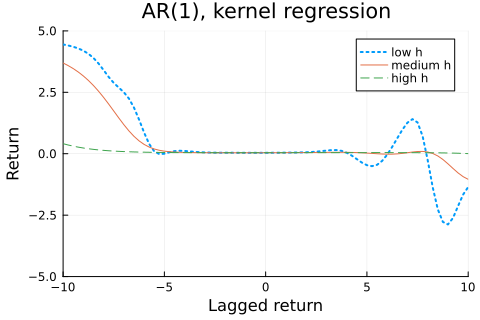

In [9]:
p1 = plot( xGrid,[bHatLoh bHat bHatHih],
           linestyle = [:dot :solid :dash],
           linewidth = [2 1 1],
           label = ["low h" "medium h" "high h"],
           xlim = extrema(xGrid),
           ylim = (-5,5),
           title = "AR(1), kernel regression",
           xlabel = "Lagged return",
           ylabel = "Return" )
display(p1)

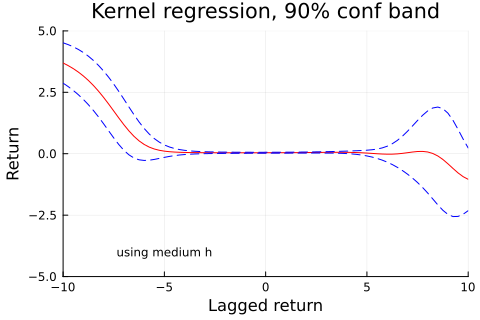

In [10]:
p1 = plot( xGrid,[bHat (bHat-1.645*StdbHat) bHat+1.645*StdbHat],
           linecolor = [:red :blue :blue],
           linestyle = [:solid :dash :dash],
           label = "",
           title = "Kernel regression, 90% conf band",
           xlabel = "Lagged return",
           ylabel = "Return",
           xlim = extrema(xGrid),
           ylim = (-5,5),
           annotation = (-5,-4,text("using medium h",8)))
display(p1)

## Rule of Thumb Choice of h

for the non-parametric regression.

Run the regression 

$
y=\alpha+\beta x+\gamma x^{2}+\varepsilon
$

and use the following rule-of-thumb choice

$
h  =T^{-1/5}|\gamma|^{-2/5}\sigma_{\varepsilon}^{2/5}(x_{\max}-x_{\min})^{1/5}\times0.6.
$

In practice, replace $x_{\max}-x_{\min}$ by the difference between the 90th
and 10th percentiles of $x$.

In [11]:
"""
    hRuleOfThumb(y,x)

Rule of thumb bandwidth for regressing y on x.
"""
function hRuleOfThumb(y,x)

    (b,res,)     = OlsGMFn(y,[x.^2 x ones(T)])
    (σ,γ)        = (std(res), b[1])
    (x_10,x_90)  = quantile(x,[0.1,0.9])             #10th and 90th percentiles

    h_rot = 0.6*σ^(2/5)*abs(γ)^(-2/5)*(x_90-x_10)^(1/5)*T^(-1/5)

    return h_rot
end

h_crude = hRuleOfThumb(y,x)
printlnPs("\nRule-of-thumb value of h: ",h_crude)


Rule-of-thumb value of h:      0.667


## Cross-Validation (extra)

to choose the bandwidth $h$ for the kernel regression.

To do a cross-validation (leave-one-out)

(1) Pick a bandwidth $h$, do the kernel regression
but leave out observation $t$ and then record the out-of-sample prediction error $y_{t}-\hat{b}_{-t}
(x_{t},h)$. Notice that this is the error for observation $t$ only. 

(2) Repeat for all $t=1-T$ to calculate the EPE

$
\text{EPE}(h)=\sum_{t=1}^{T}[  y_{t}-\hat{b}_{-t}(x_{t},h)]  ^{2}/T,
$

(3) Finally, redo for several different values of $h$, and pick the $h$ value
that minimizes $\text{EPE}(h)$. 

### A Remark on the Code

Notice: Cross-validation calculations *take some time*. To save some computations the standard errors (which are not needed)
are not calculated.

In [12]:
hM = h_crude*[0.5,0.75,1,1.5,2,3,4,5,10]   #candiate h values

Nh   = length(hM)
EPEM = fill(NaN,(T,Nh))
for t = 1:T
    local v_No_t, b_t
    v_No_t = setdiff(1:T,t)     #exclude t from estimation
    for j = 1:Nh                #loop over hM[j] values
        b_t,      = KernRegFn(y,x,x[t],hM[j],v_No_t,false)  #calculate fitted b(x[t])
        EPEM[t,j] = (y[t] - b_t[1])^2     #out-of-sample error
    end
end

EPE = mean(EPEM,dims=1)'

printblue("Cross-validation of bandwidth (h):\n")
printmat([hM EPE],colNames=["h","EPE"])

Cross-validation of bandwidth (h):

         h       EPE
     0.334     1.314
     0.501     1.302
     0.667     1.295
     1.001     1.288
     1.335     1.286
     2.002     1.287
     2.670     1.291
     3.337     1.292
     6.674     1.296



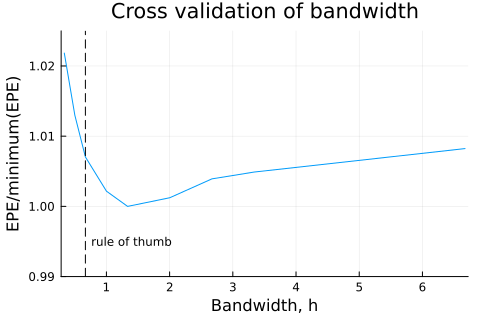

In [13]:
p1 = plot( hM,EPE/minimum(EPE),
           legend = false,
           xlim = (minimum(hM)-0.05,maximum(hM)+0.05),
           ylim = (0.99,1.025),
           title = "Cross validation of bandwidth",
           xlabel = "Bandwidth, h",
           ylabel = "EPE/minimum(EPE)",
           annotation = (1.4,0.995,text("rule of thumb",8)) )
vline!([h_crude],linecolor=:black,line=(:dash,1)) 
display(p1)

# Local Linear Regression

estimates 

$y_t = a + b (x_t-x) + \epsilon_t$

for a grid of $x$ values. This can also be implemented as weighted least squares (which gives both point estimates and valid standard errors).


In [14]:
"""
    LocalLinearRegFn(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)

Do local linear regression y = a + b(x-xGrid[i]), where both a and b will differ
across `xGrid[i]` values. The estimates of a and their standard errors are
exported.

See KernRegrFn() for further comments

"""
function LocalLinearFn(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)

    if vv != :all
        (y,x) = (y[vv],x[vv])
    end
    c = ones(length(y))          

    Ngrid = length(xGrid)                  #number of grid points

    (aHat,StdaHat) = (fill(NaN,Ngrid),fill(NaN,Ngrid))         #b[x(t)]
    for i = 1:Ngrid                        #loop over elements in xGrid
        zi  = (x .- xGrid[i])/h
        w   = KernelFun.(zi)
        w05 = sqrt.(w)
        x2  = hcat(c,x .- xGrid[i])
        if DoCovb
            (b_i,_,_,Covb_i,) = OlsNWFn(w05.*y,w05.*x2,0)
            aHat[i]    = b_i[1]
            StdaHat[i] = sqrt(Covb_i[1,1])
        else    
            b_i     = (w05.*x2)\(w05.*y)
            aHat[i] = b_i[1]
        end    
    end

    return aHat, StdaHat

end

LocalLinearFn

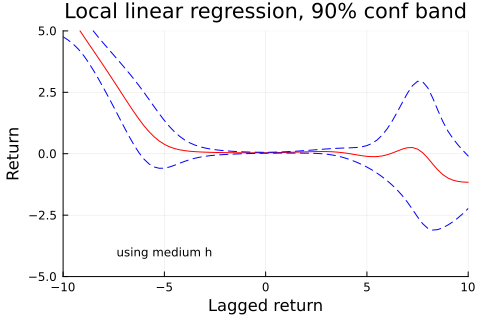

In [15]:
xGrid = -10:0.25:10                          #x values to estimate b(x) at
h     = 1.5
(aHat,StdaHat) = LocalLinearFn(y,x,xGrid,h);             #baseline choice of h

p1 = plot( xGrid,[aHat (aHat-1.645*StdaHat) aHat+1.645*StdaHat],
           linecolor = [:red :blue :blue],
           linestyle = [:solid :dash :dash],
           label = "",
           title = "Local linear regression, 90% conf band",
           xlabel = "Lagged return",
           ylabel = "Return",
           xlim = extrema(xGrid),
           ylim = (-5,5),
           annotation = (-5,-4,text("using medium h",8)))
display(p1)